# **FULLY CONNECTED - SECOND VERSION**

Fully connected model with 4 hiddel layers, 200 neurons in input and 3 in output (autoregressive framework). The number of neurons along the network steadily decrease from 32 to 4, with no batch or dropout

**PROBLEM DESCRIPTION**: develop a forecasting model that is able to predict several uncorrelated time series

**DATA STRUCTURE**: Single folder containing the following files: -> 'training_data.npy': it contains a numpy array of shape (48000, 2776). 48000 time series of length 2776. -> 'valid_periods.npy': it contains a numpy array of type (48000, 2) containing for each of the time series the start and end index of the current series, i.e. the part without padding. -> 'categories.npy': it contains a numpy array of shape (48000,), containing for each of the time series the code of its category. The possible categories are in {'A', 'B', 'C', 'D', 'E', 'F'}. IMPORTANT: This is a dataset consisting of monovariate time series, i.e. composed of a single feature, belonging to six different domains. The time series of each domain are not to be understood as closely related to each other, but only as collected from similar data sources. What is required of you is therefore to build a model that is capable of generalising sufficiently to predict the future samples of the 60 time series of the test set.

In [28]:
# Import libraries and connect to drive personal folder

from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive/My Drive/homework_2/Emanuele

# Fix randomness and hide warnings
seed = 42

import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
os.environ['PYTHONHASHSEED'] = str(seed)
os.environ['MPLCONFIGDIR'] = os.getcwd()+'/configs/'

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=Warning)

import numpy as np
np.random.seed(seed)

import logging

import random
random.seed(seed)

# Import tensorflow
import tensorflow as tf
from tensorflow import keras as tfk
from tensorflow.keras import layers as tfkl
from keras import backend as K
from keras.callbacks import TensorBoard
tf.autograph.set_verbosity(0)
tf.get_logger().setLevel(logging.ERROR)
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)
print(tf.__version__)


# Import other support libraries

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
plt.rc('font', size=16)
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import MinMaxScaler
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf


Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).
/gdrive/My Drive/homework_2/Emanuele
2.15.0


In [29]:
training_data = np.load('training_data.npy')
categories = np.load('categories.npy')
valid_periods = np.load('valid_periods.npy')
print(training_data.shape)
print(categories.shape)
print(valid_periods.shape)

(48000, 2776)
(48000,)
(48000, 2)


# **Plotting of some time series**

Text(0.5, 0.98, 'First 10 time series without padding and normalized')

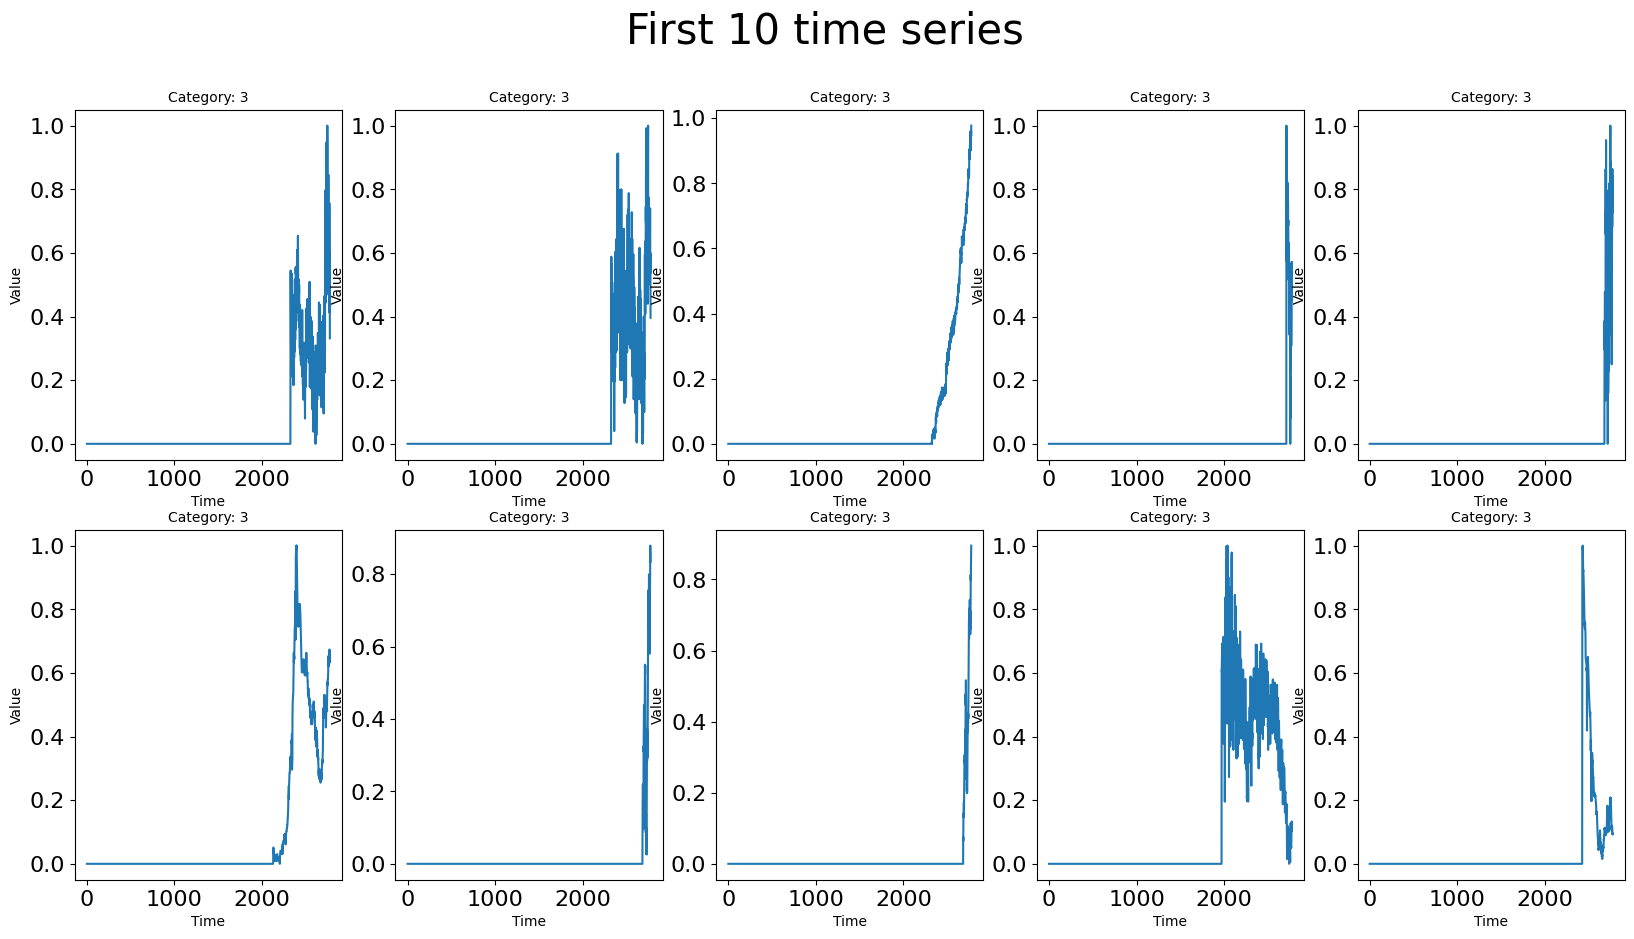

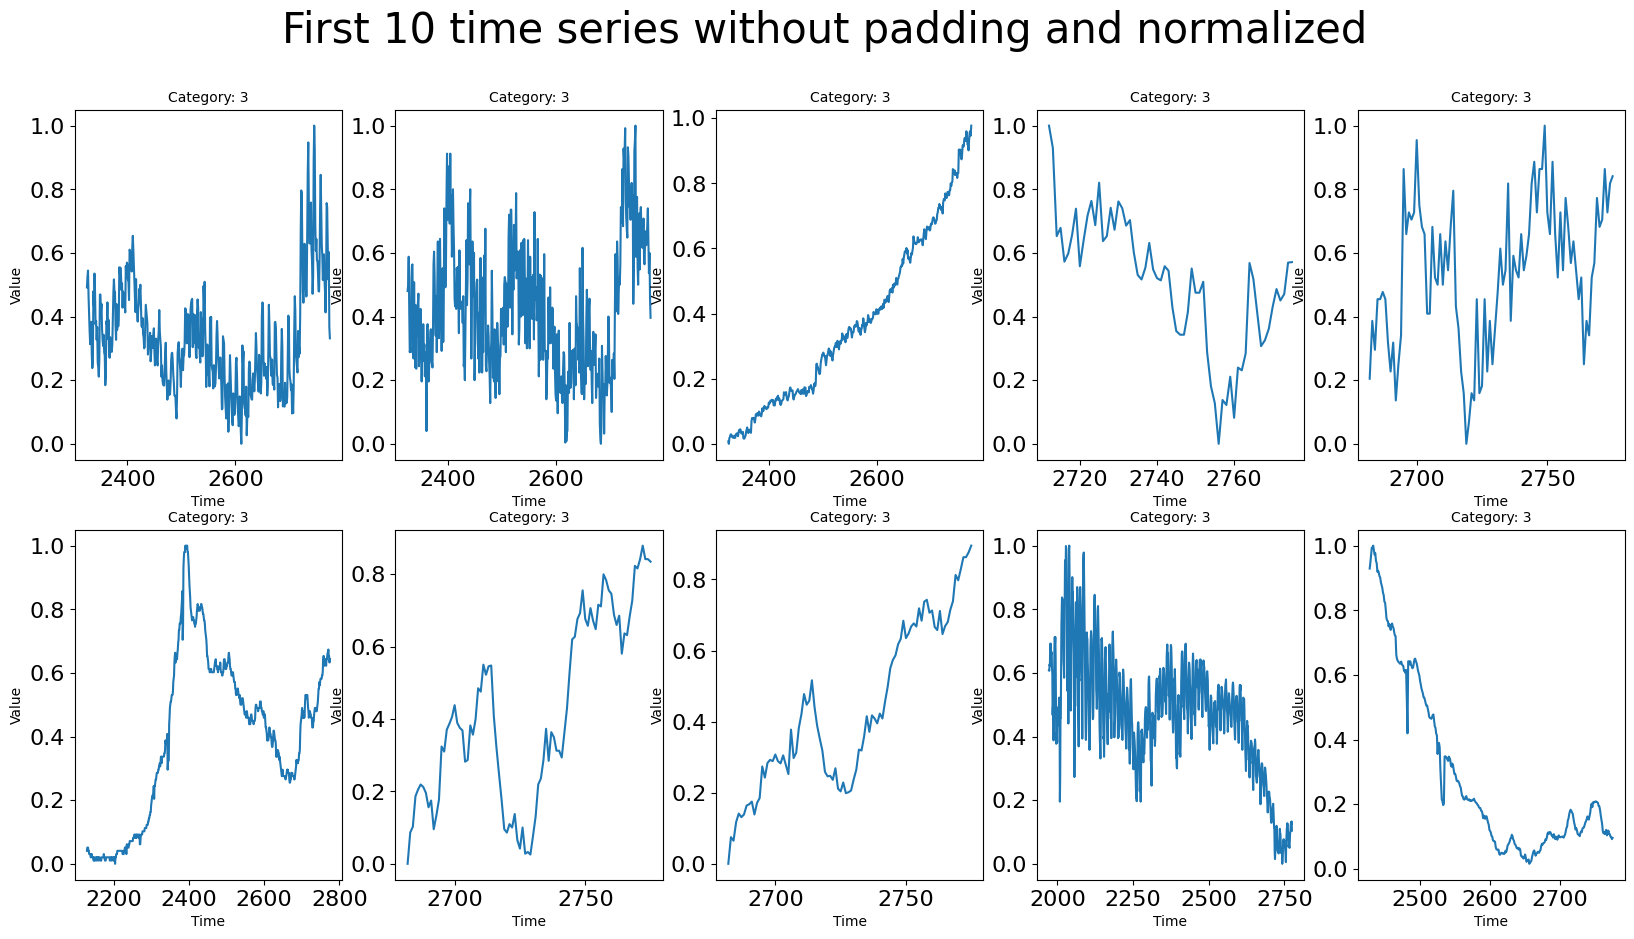

In [30]:
# -----------------------------------* DATA ANALYSIS *---------------------------------------

# Note that all the values are store as float64, so we can convert them to float32 to save memory
if training_data.dtype == np.float64:
    training_data = training_data.astype(np.float32)

# Then transform the categories into numbers
categorical_to_numerical = {'A': 0, 'B': 1, 'C': 2, 'D': 3, 'E': 4, 'F':5}

if categories[0] == "D":
    for category in np.unique(categories):
        categories[categories == category] = categorical_to_numerical[category]
    # To save memory, convert the categories to int32
    categories = categories.astype(np.int32)

# -<-<-<-<-<-<-<-<-<-< FIRST PLOTS AND PADDING REMOVAL/NORMALIZATION >->->->->->->->->->->-

# Plot the first 10 time series

fig, axs = plt.subplots(2, 5, figsize=(20, 10))
axs = axs.ravel()
for i in range(10):
    axs[i].plot(training_data[i])
    axs[i].set_title('Category: {}'.format(categories[i]), fontsize=10)
    axs[i].set_xlabel('Time', fontsize=10)
    axs[i].set_ylabel('Value', fontsize=10)

fig.suptitle('First 10 time series', fontsize=30)

# -<-<-<-<-<-<-<-<-<-<-<-< DATA NORMLIZATION >->->->->->->->->->->->->-
# AS THE DATA HAS ALREADY BEEN NORMALIZED (EACH ROW HAS BEEN NORMALIZED INDIPENDENTLY)
# WE DEEMED THIS STEP NOT NECESSARY

# Define min_max normalization function
def min_max_norm(data, min, max):
    return (data - min) / (max - min)

# Apply the function over the categories singularly
def min_max_norm_by_category(data, categories):
    # Loop over the categories
    for category in np.unique(categories):
        # For each category compute the min and max
        C_min = np.min(np.concatenate(data[categories == category]))
        C_max = np.max(np.concatenate(data[categories == category]))
        # Apply the min_max_norm function to the data of the current category
        data[categories == category] = min_max_norm(data[categories == category], C_min, C_max)
    return data

# Function to apply a robust scaler on each non-padded time series per category
def robust_scaler(data, categories):
    # Loop over the categories
    for category in np.unique(categories):
        # Group the data by category
        data_cat = data[categories == category]
        # Compute the median and the IQR for the current category by concatenating the time series
        median = np.median(np.concatenate(data_cat))
        IQR = np.percentile(np.concatenate(data_cat), 75) - np.percentile(np.concatenate(data_cat), 25)
        # Apply the robust scaler to the data of the current category
        data[categories == category] = (data[categories == category] - median) / IQR
    return data


# -<-<-<-<-<-<-<-<-<-<  PADDING REMOVAL >->->->->->->->->->-
# Define a function to remove the padding from the time series

def remove_padding(data, valid_periods):
    data_no_pad = []
    for i in range(data.shape[0]):
        data_no_pad.append(data[i, valid_periods[i, 0]:valid_periods[i, 1]])
    return np.array(data_no_pad)


# Remove the padding from the time series
training_data_no_pad = remove_padding(training_data, valid_periods)

# Call the function for robust scaler normalization
#training_data_no_pad = robust_scaler_normalization(training_data_no_pad, categories)

# Call the functino for min-max scaling
#training_data_no_par = min_max_norm_by_category(training_data_no_pad,categories)

# Plot the first 10 time series without padding, keeping the information about the orignal temporal location
fig, axs = plt.subplots(2, 5, figsize=(20, 10))
axs = axs.ravel()
for i in range(10):
    axs[i].plot(range(valid_periods[i, 0], valid_periods[i, 1]), training_data_no_pad[i])
    axs[i].set_title('Category: {}'.format(categories[i]), fontsize=10)
    axs[i].set_xlabel('Time', fontsize=10)
    axs[i].set_ylabel('Value', fontsize=10)

fig.suptitle('First 10 time series without padding and normalized', fontsize=30)

# All this samples belong to category D, and are "to be understood as not closely related to each other, but only as collected from similar data sources"
# This means that the time seies within the same categoty are to be considered as uncorrelated, but should there not be a correlation between the catoegories?




# **Plot data distribution, mean lenght, autocorrelation and partial autocorrelation**

---

{0: 0.00017458100558659218, 1: 9.101665604805679e-05, 2: 9.98302885095338e-05, 3: 9.984025559105431e-05, 4: 9.111617312072893e-05, 5: 0.0036101083032490976}


Text(0.5, 0.98, 'Partial auto-correlation')

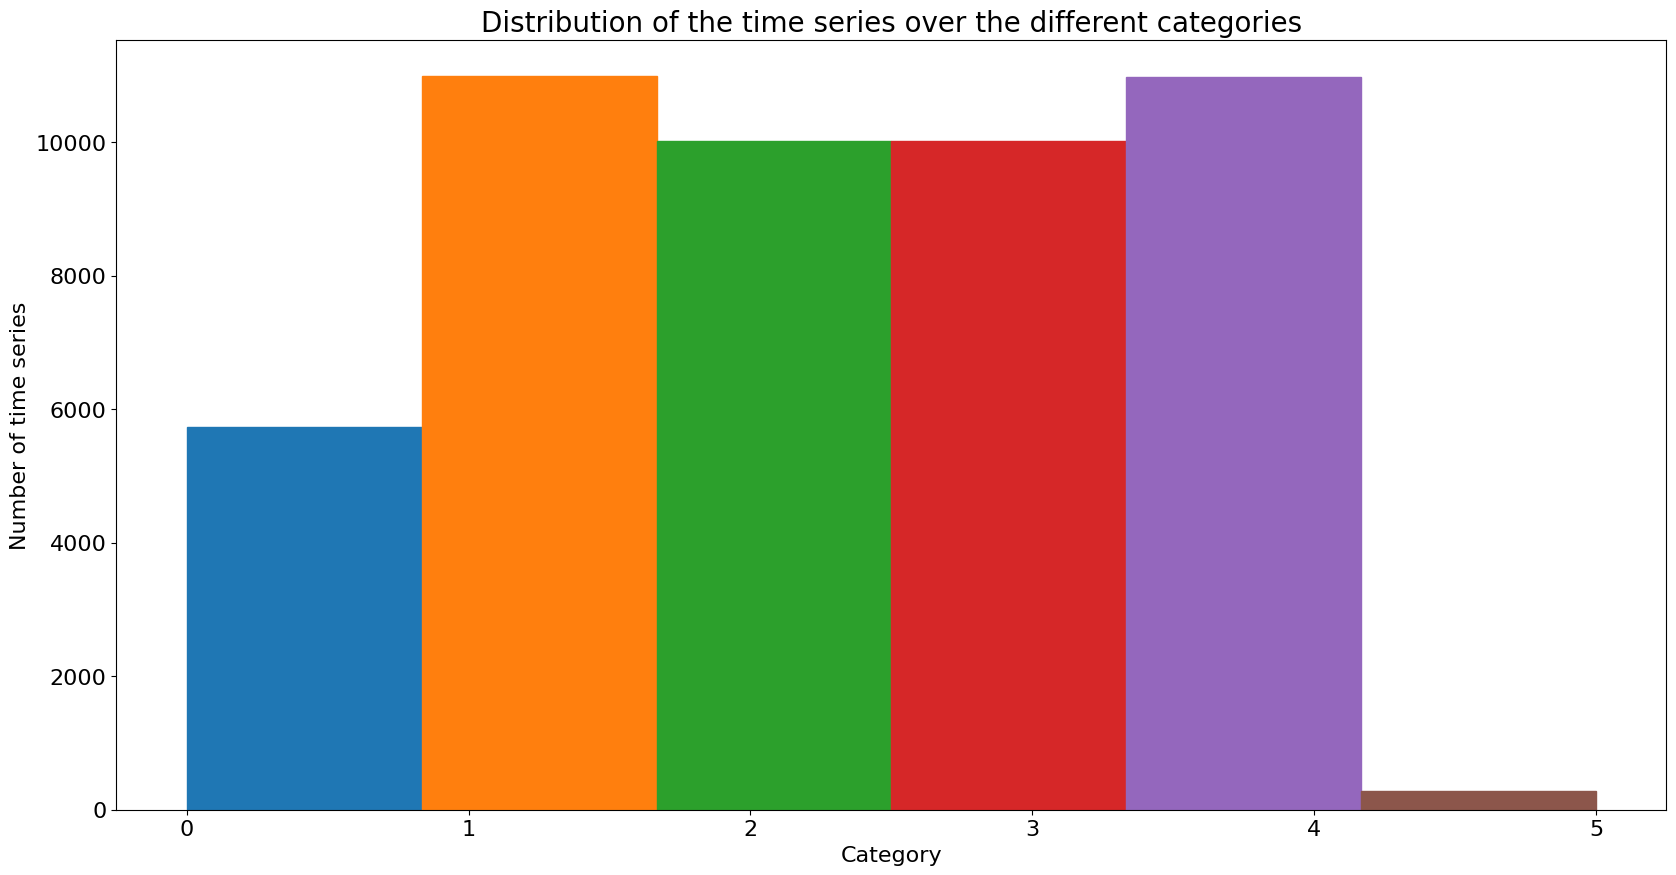

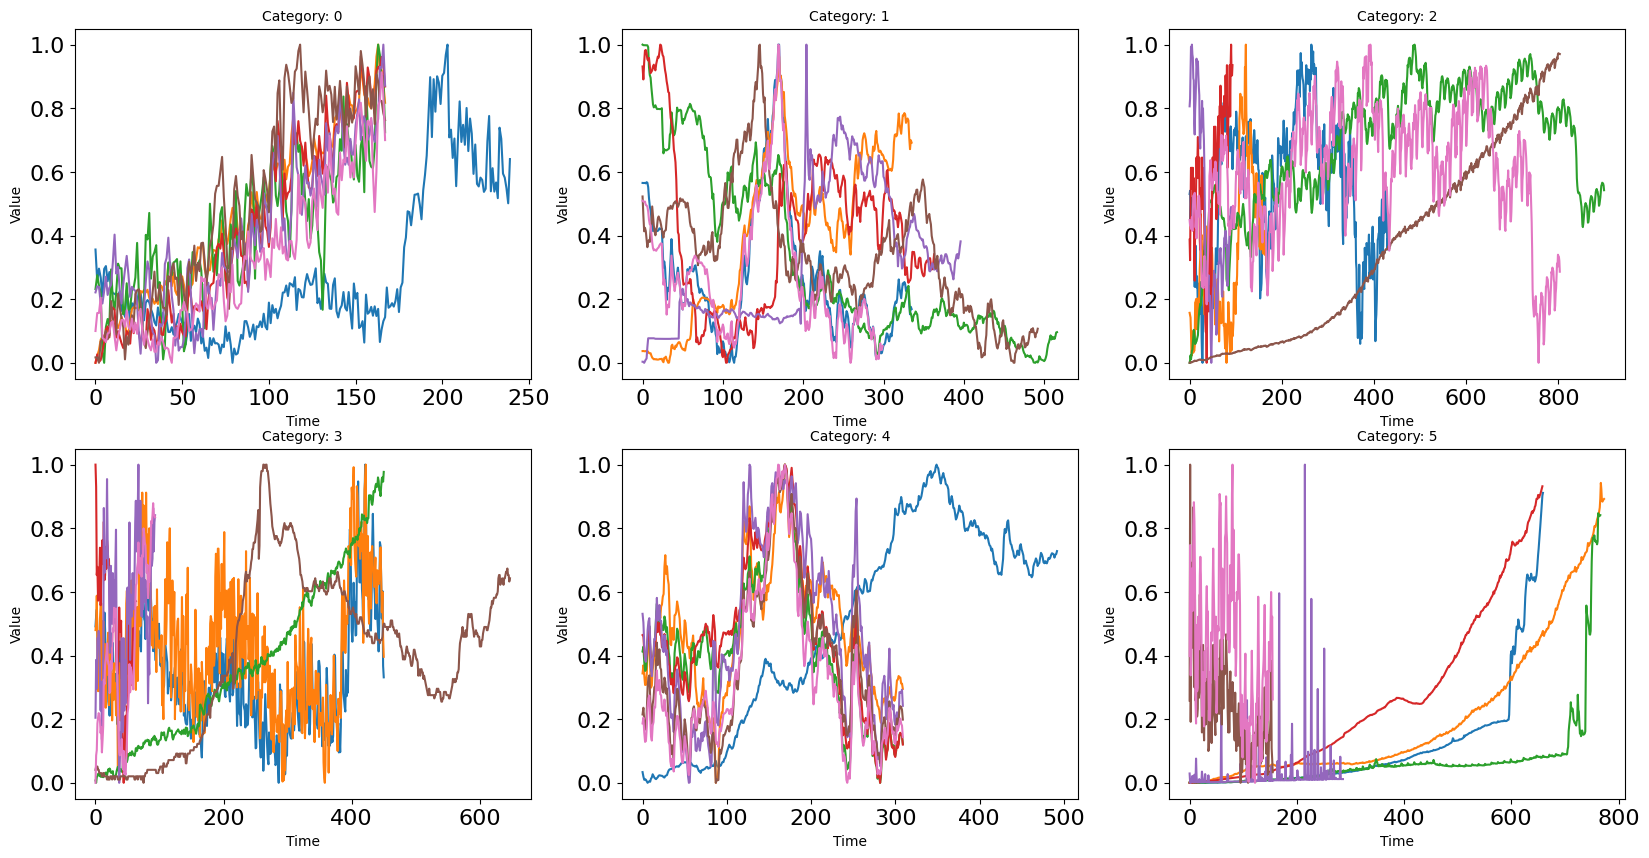

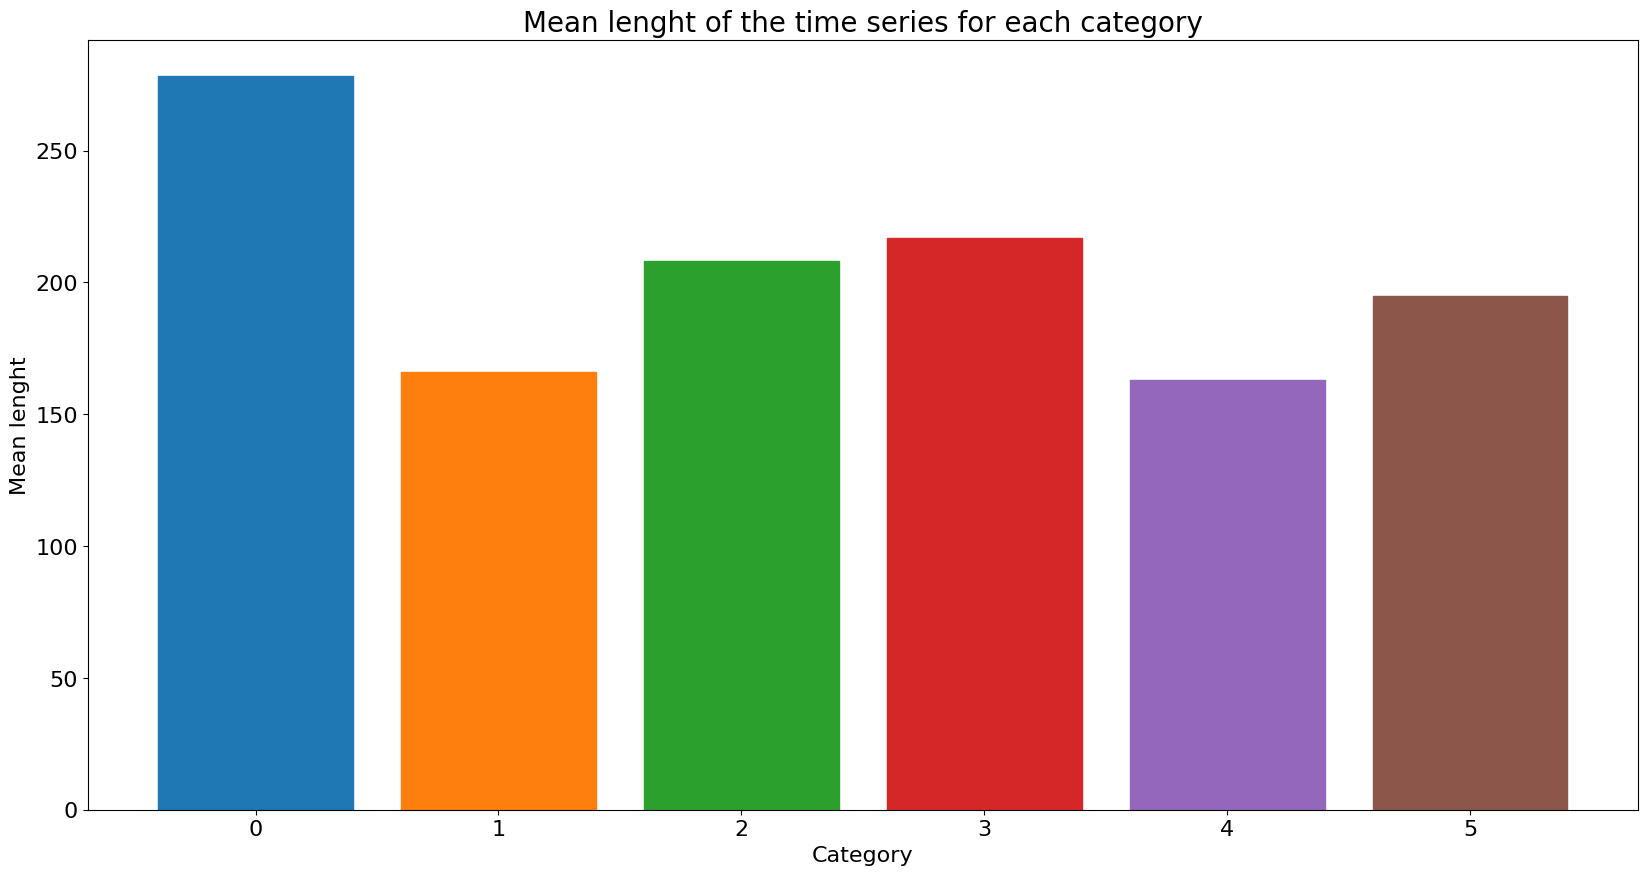

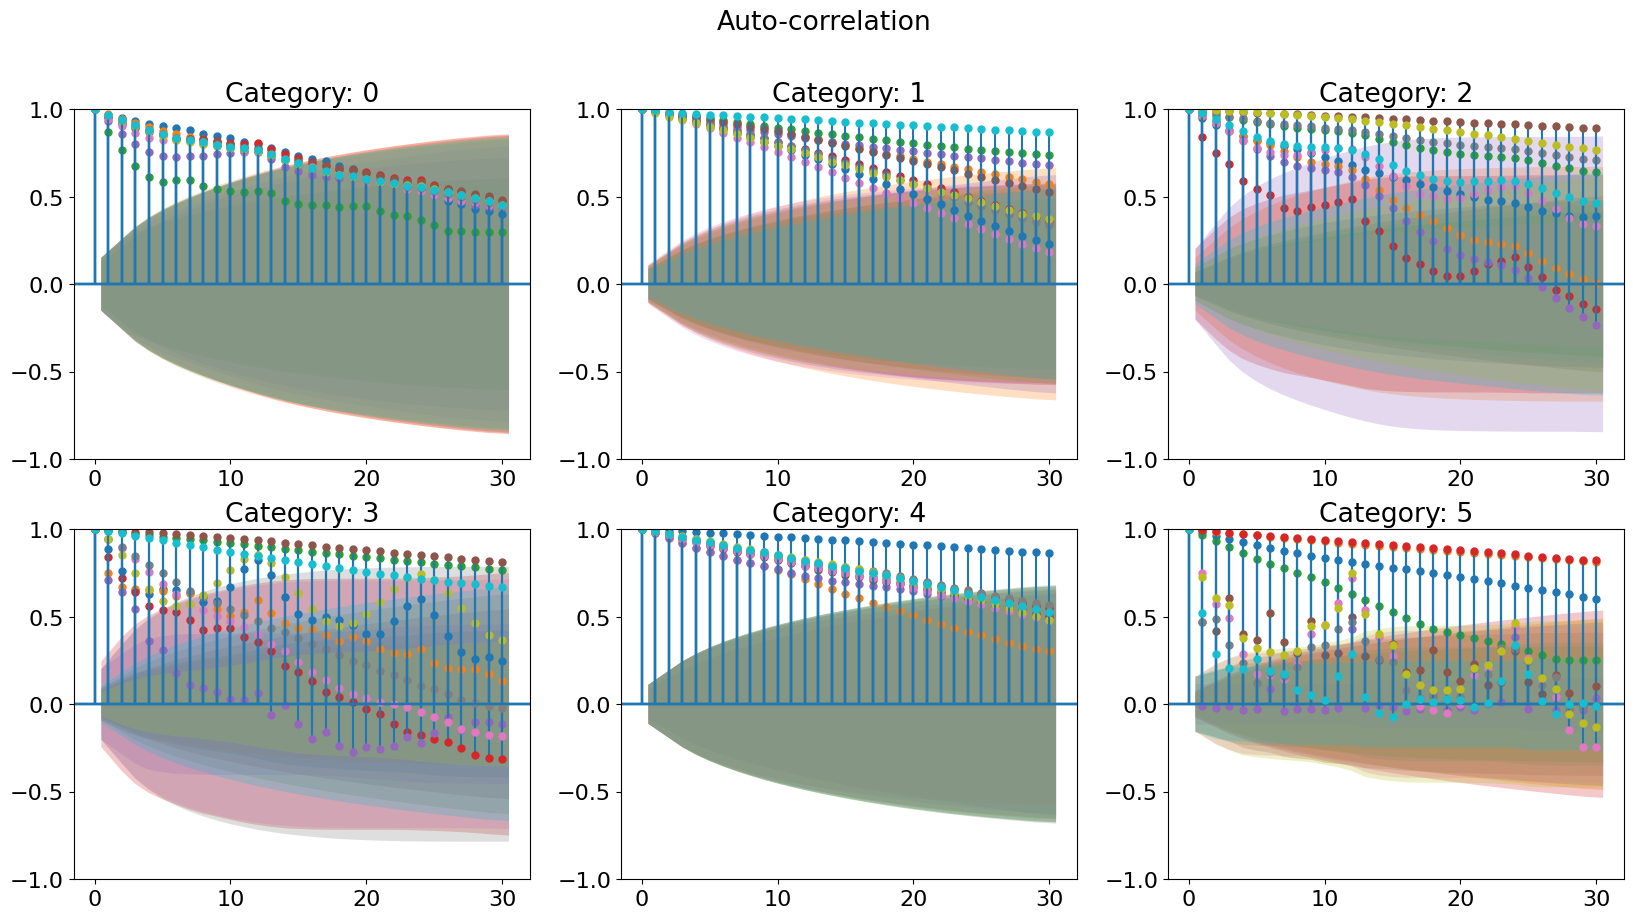

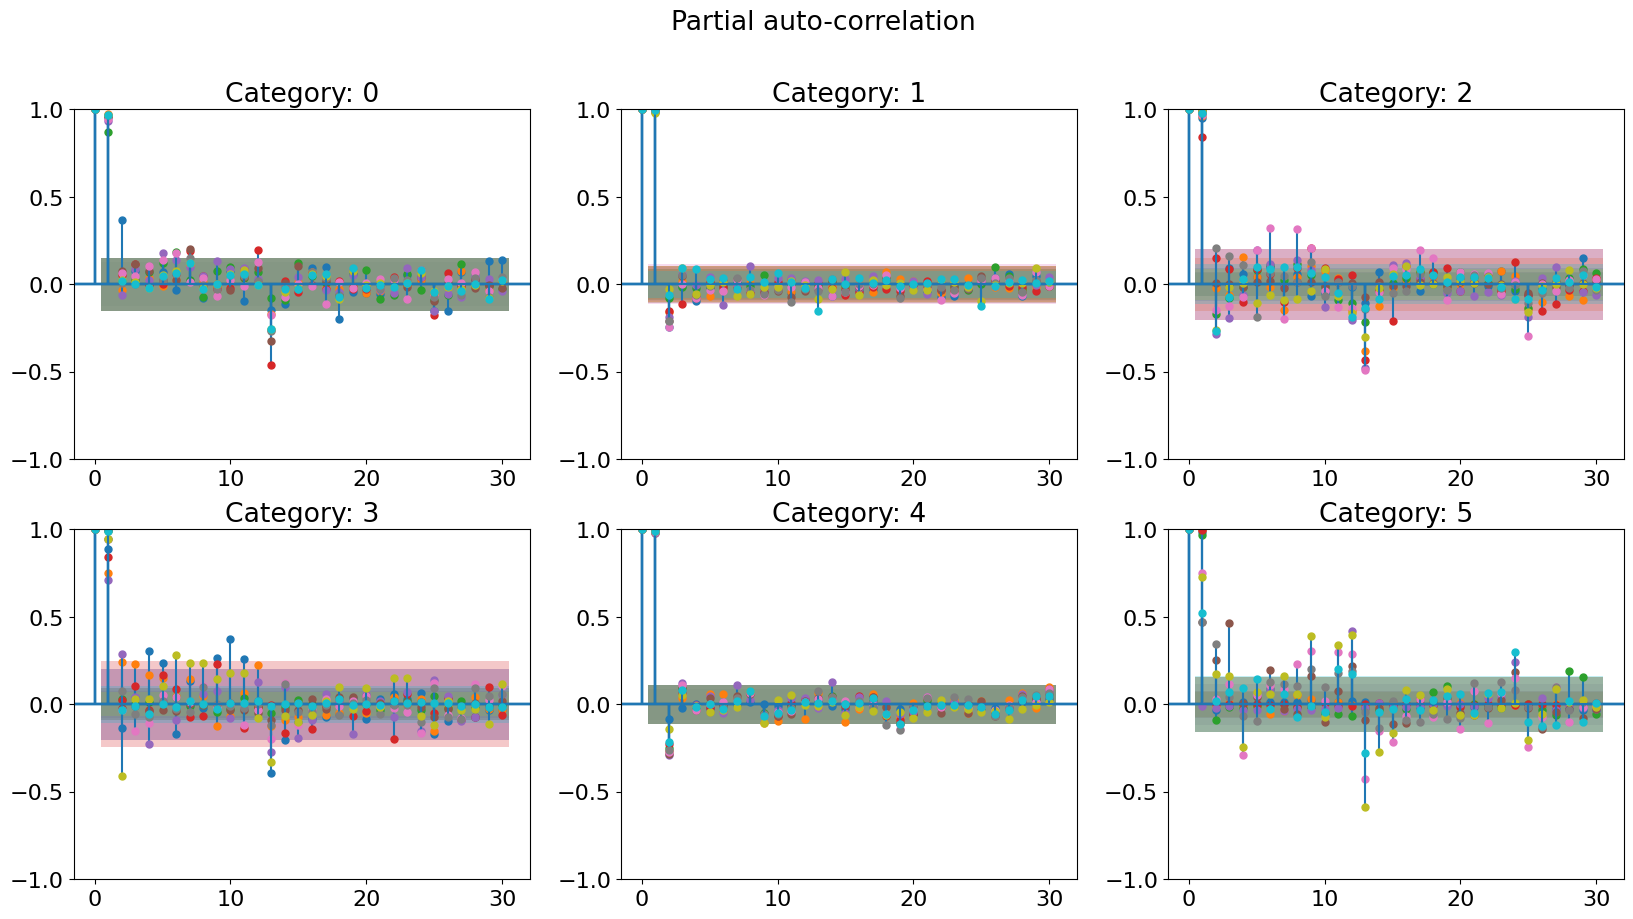

In [31]:

# -<-<-<-<-<-<-<-<-<-< DATA DISTRIBUTION ANALYSIS >->->->->->->->->->->-


# GROUP DATA BY CATEGORY:

# Now plot the distribution of the time series over the different categories
fig, ax = plt.subplots(figsize=(20, 10))
ax.hist(categories, bins=6)
ax.set_title('Distribution of the time series over the different categories', fontsize=20)
ax.set_xlabel('Category')
ax.set_ylabel('Number of time series')
# separate the bars and use different colors
for i in range(6):
    ax.patches[i].set_color('C{}'.format(i))
plt.xticks(np.arange(6))

# OSS: a visible imbalance between the categories is present, with category 5 been extremely underrepresented
# (category 1 is just slightly underrepresented, while the other categories are more or less equally represented)

# Compute class_weight paramenter to be used for the fit of the model
weights = {}
for i in range(6):
    weights[i] = 1 / np.sum(categories == i)
print(weights)


# -<-<-<-<-<-<-< PLOT OF FIRST TIME SERIES FOR DIFFERENT CATEGORIES >->->->->->-
# Plot the first n time series for each category (6 diffrerent plots, with multiple time series in each plot)

n = 7
fig, axs = plt.subplots(2, 3, figsize=(20, 10))
axs = axs.ravel()
for i in range(6):
    for j in range(n):
      axs[i].plot(training_data_no_pad[categories == i][j])
    axs[i].set_title('Category: {}'.format(i), fontsize=10)
    axs[i].set_xlabel('Time', fontsize=10)
    axs[i].set_ylabel('Value', fontsize=10)

# -<-<-<-<-<-<-< PLOT OF TIME SERIES BY LENGHT AND DOMAIN  >->->->->->-

# Compute mean lenght of the time series for each category and plot them in a bar plot
mean_lenght = []
for i in range(6):
    mean_lenght.append(np.mean(valid_periods[categories == i, 1] - valid_periods[categories == i, 0]))
fig, ax = plt.subplots(figsize=(20, 10))
ax.bar(np.arange(6), mean_lenght)
ax.set_title('Mean lenght of the time series for each category', fontsize=20)
ax.set_xlabel('Category')
ax.set_ylabel('Mean lenght')
plt.xticks(np.arange(6))
for i in range(6):
    ax.patches[i].set_color('C{}'.format(i))

# OSS: a fairly similar mean lenght for all the categories

# -<-<-<-<-<-<-<-<-<-<-< AUTO-CORRELATION  and  PARTIAL AUTO-CORRELATION PLOT >->->->->->->->->->->->->-

# Plot the auto-correlation and partial auto-correlation for the first 10 time series of each category
# The auto-correlation is computed by the function acf of the statsmodels library
# The partial auto-correlation is computed by the function pacf of the statsmodels library

n = 10
fig, axs = plt.subplots(2, 3, figsize=(20, 10))
axs = axs.ravel()
for i in range(6):
    for j in range(n):
        plot_acf(training_data_no_pad[categories == i][j], ax=axs[i], lags=30, title='Category: {}'.format(i))
fig.suptitle('Auto-correlation')

fig, axs = plt.subplots(2, 3, figsize=(20, 10))
axs = axs.ravel()
for i in range(6):
    for j in range(n):
        plot_pacf(training_data_no_pad[categories == i][j], ax=axs[i], lags=30, title='Category: {}'.format(i))
fig.suptitle('Partial auto-correlation')

# Use this information to set an AUTOREGRESSIVE-TELESCOPE of value 3





# **Data splitting and definition of some hyperparameters**

---

In [32]:
# Define some Hyperparameters for the forcasting model
WINDOW_SIZE = 200
BATCH_SIZE = 256
STRIDE = 10
EPOCHS = 100
VALIDATION_SPLIT = 0.2
TEST_SPLIT = 0.03
TELESCOPE = 18
AUTOREGRESSIVE_TELESCOPE = 3
assert AUTOREGRESSIVE_TELESCOPE < TELESCOPE

# In this case, given the nature of the problem, as well as the fact that the time series are not correlated
# (so introducing some of them in training phase should now bias the test), we decide
# to make use of the great variaty of time series available, and split data among the time series themselves:

# This way, a certain percentage of the time series will be used for training (80% initial partition), while the remaining ones will be used for validation (20).
# In both case, we define the number of samples to be predicted as TELESCOPE, and the number of samples to be used for the prediction as WINDOW_SIZE.

# For the testing, we respect the imbalances among the different domains using stratify based on the categories

X_train_raw, X_test_raw, domains_train, domains_test = train_test_split(training_data_no_pad, categories, test_size=TEST_SPLIT, stratify=categories)
X_train_raw, X_val_raw, domains_train, domains_val = train_test_split(X_train_raw, domains_train, test_size=VALIDATION_SPLIT, stratify=domains_train)

In [33]:
# -----------------------------------* DATA PREPROCESSING *---------------------------------------
# Build the sequences for the forecasting model: in this case, we will try to take into account the
# imbalance between the categories usign a weighted loss function

# The function lets us build the sequences to use for the training of the forecasting model:
# In this case, given a certain domain (category), the function will build the sequences to be used for the training
# by extracting temporal windows out of each time series.
# Please note tha some of the time series will takes as they are, since they are shorter than the window size.
# In some other cases, the time series are "partioned" in windows of the same size, and the last window is padded with zeros
# In any case, for the correct creation of the sequences, dataset to be passed to the function must be the one without padding
def build_sequences_on_domain(data, categories_split  ,domain = 0, window=200, stride=20, telescope=100):
    # Sanity check to avoid runtime errors
    assert window % stride == 0
    dataset = []
    labels = []
    categories = []
    temp_df = data[categories_split == domain]
    temp_label = temp_df.copy()
    # For each time series of the specific domain, compute the padding lenght
    # OSS... This is done on the data without padding
    for time_series_n in range(len(temp_df)):
        padding_len = (window + telescope) - len(temp_df[time_series_n])
        if(padding_len > 0):
            padding = np.zeros((padding_len), dtype='float32')
            temp_df[time_series_n] = np.concatenate((padding,temp_df[time_series_n]))
            padding = np.zeros((padding_len), dtype='float32')
            temp_label[time_series_n] = np.concatenate((padding,temp_label[time_series_n]))


    for time_series_n in range(len(temp_df)):
          for i in np.arange(0, len(temp_df[time_series_n])-window-telescope, stride):
              dataset.append(temp_df[time_series_n][i:i+window])
              labels.append(temp_label[time_series_n][i+window:i+window+telescope])
              categories.append(domain)

    dataset = np.array(dataset)
    labels = np.array(labels)
    categories = np.array(categories)
    return dataset, labels, categories

def inspect_multivariate(X, y, telescope, idx=None, data_to_plot= 5):
    if(idx==None):
        idx=np.random.randint(0,len(X))

    # Plot three sequences chosen based on idx
    figs, axs = plt.subplots(data_to_plot, 1, sharex=True, figsize=(30,15))
    for i in range(idx, idx+data_to_plot):
        axs[i-idx].plot(np.arange(len(X[i])), X[i])
        axs[i-idx].scatter(np.arange(len(X[i]), len(X[i])+telescope), y[i], color='orange')
        axs[i-idx].set_title('Sequence {}'.format(i))
    plt.show()


def inspect_multivariate_prediction(X, y, pred, telescope,categories = None, idx=None, data_to_plot= 5):

    if categories is not None:
        #Plot a single sequence for each category:
        # loop over the samples and plot one for each category
        if (idx == None):
          idx = np.random.randint(0, len(X[categories == 5]))
        figs, axs = plt.subplots(6, 1, sharex=True, figsize=(30,15))
        for i in range(6):
            axs[i].plot(np.arange(len(X[categories == i][idx])), X[categories == i][idx])
            axs[i].scatter(np.arange(len(X[categories == i][idx]), len(X[categories == i][idx])+telescope), y[categories == i][idx], color='orange')
            axs[i].scatter(np.arange(len(X[categories == i][idx]), len(X[categories == i][idx])+telescope), pred[categories == i][idx], color='green')
            axs[i].set_title('Category {}'.format(i))
        plt.show()
    else:

        if(idx==None):
          idx=np.random.randint(0,len(X))
        # Plot data_to_plot sequences chosen based on idx
        figs, axs = plt.subplots(data_to_plot, 1, sharex=True, figsize=(30,15))
        for i in range(idx, idx+data_to_plot):
            axs[i-idx].plot(np.arange(len(X[i])), X[i])
            axs[i-idx].scatter(np.arange(len(X[i]), len(X[i])+telescope), y[i], color='orange')
            axs[i-idx].scatter(np.arange(len(X[i]), len(X[i])+telescope), pred[i], color='green')
            axs[i-idx].set_title('Sequence {}'.format(i))
        plt.show()

In [34]:
X_train, y_train, _ = build_sequences_on_domain(data=X_train_raw,categories_split=domains_train, domain = 0, window=WINDOW_SIZE, stride=STRIDE, telescope=AUTOREGRESSIVE_TELESCOPE)
X_val, y_val, _ = build_sequences_on_domain(data=X_val_raw,categories_split = domains_val,domain=0, window=WINDOW_SIZE, stride=STRIDE, telescope=AUTOREGRESSIVE_TELESCOPE)
X_test_reg, y_test_reg, test_categories = build_sequences_on_domain(data=X_test_raw,categories_split = domains_test,domain=0, window=WINDOW_SIZE, stride=STRIDE, telescope=TELESCOPE)
for i in range(1,6):
    X_train_temp, y_train_temp, _ = build_sequences_on_domain(data=X_train_raw,categories_split=domains_train, domain=i, window=WINDOW_SIZE, stride=STRIDE, telescope=AUTOREGRESSIVE_TELESCOPE)
    X_val_temp, y_val_temp, _ = build_sequences_on_domain(data=X_val_raw,categories_split = domains_val,domain=i, window=WINDOW_SIZE, stride=STRIDE, telescope=AUTOREGRESSIVE_TELESCOPE)
    X_test_temp, y_test_temp, test_categories_temp = build_sequences_on_domain(data=X_test_raw,categories_split = domains_test,domain=i, window=WINDOW_SIZE, stride=STRIDE, telescope=TELESCOPE)
    # Concatenate with the previous domains
    X_train = np.concatenate((X_train, X_train_temp))
    y_train = np.concatenate((y_train, y_train_temp))
    X_val = np.concatenate((X_val, X_val_temp))
    y_val = np.concatenate((y_val, y_val_temp))
    X_test_reg = np.concatenate((X_test_reg, X_test_temp))
    y_test_reg = np.concatenate((y_test_reg, y_test_temp))
    test_categories = np.concatenate((test_categories, test_categories_temp))


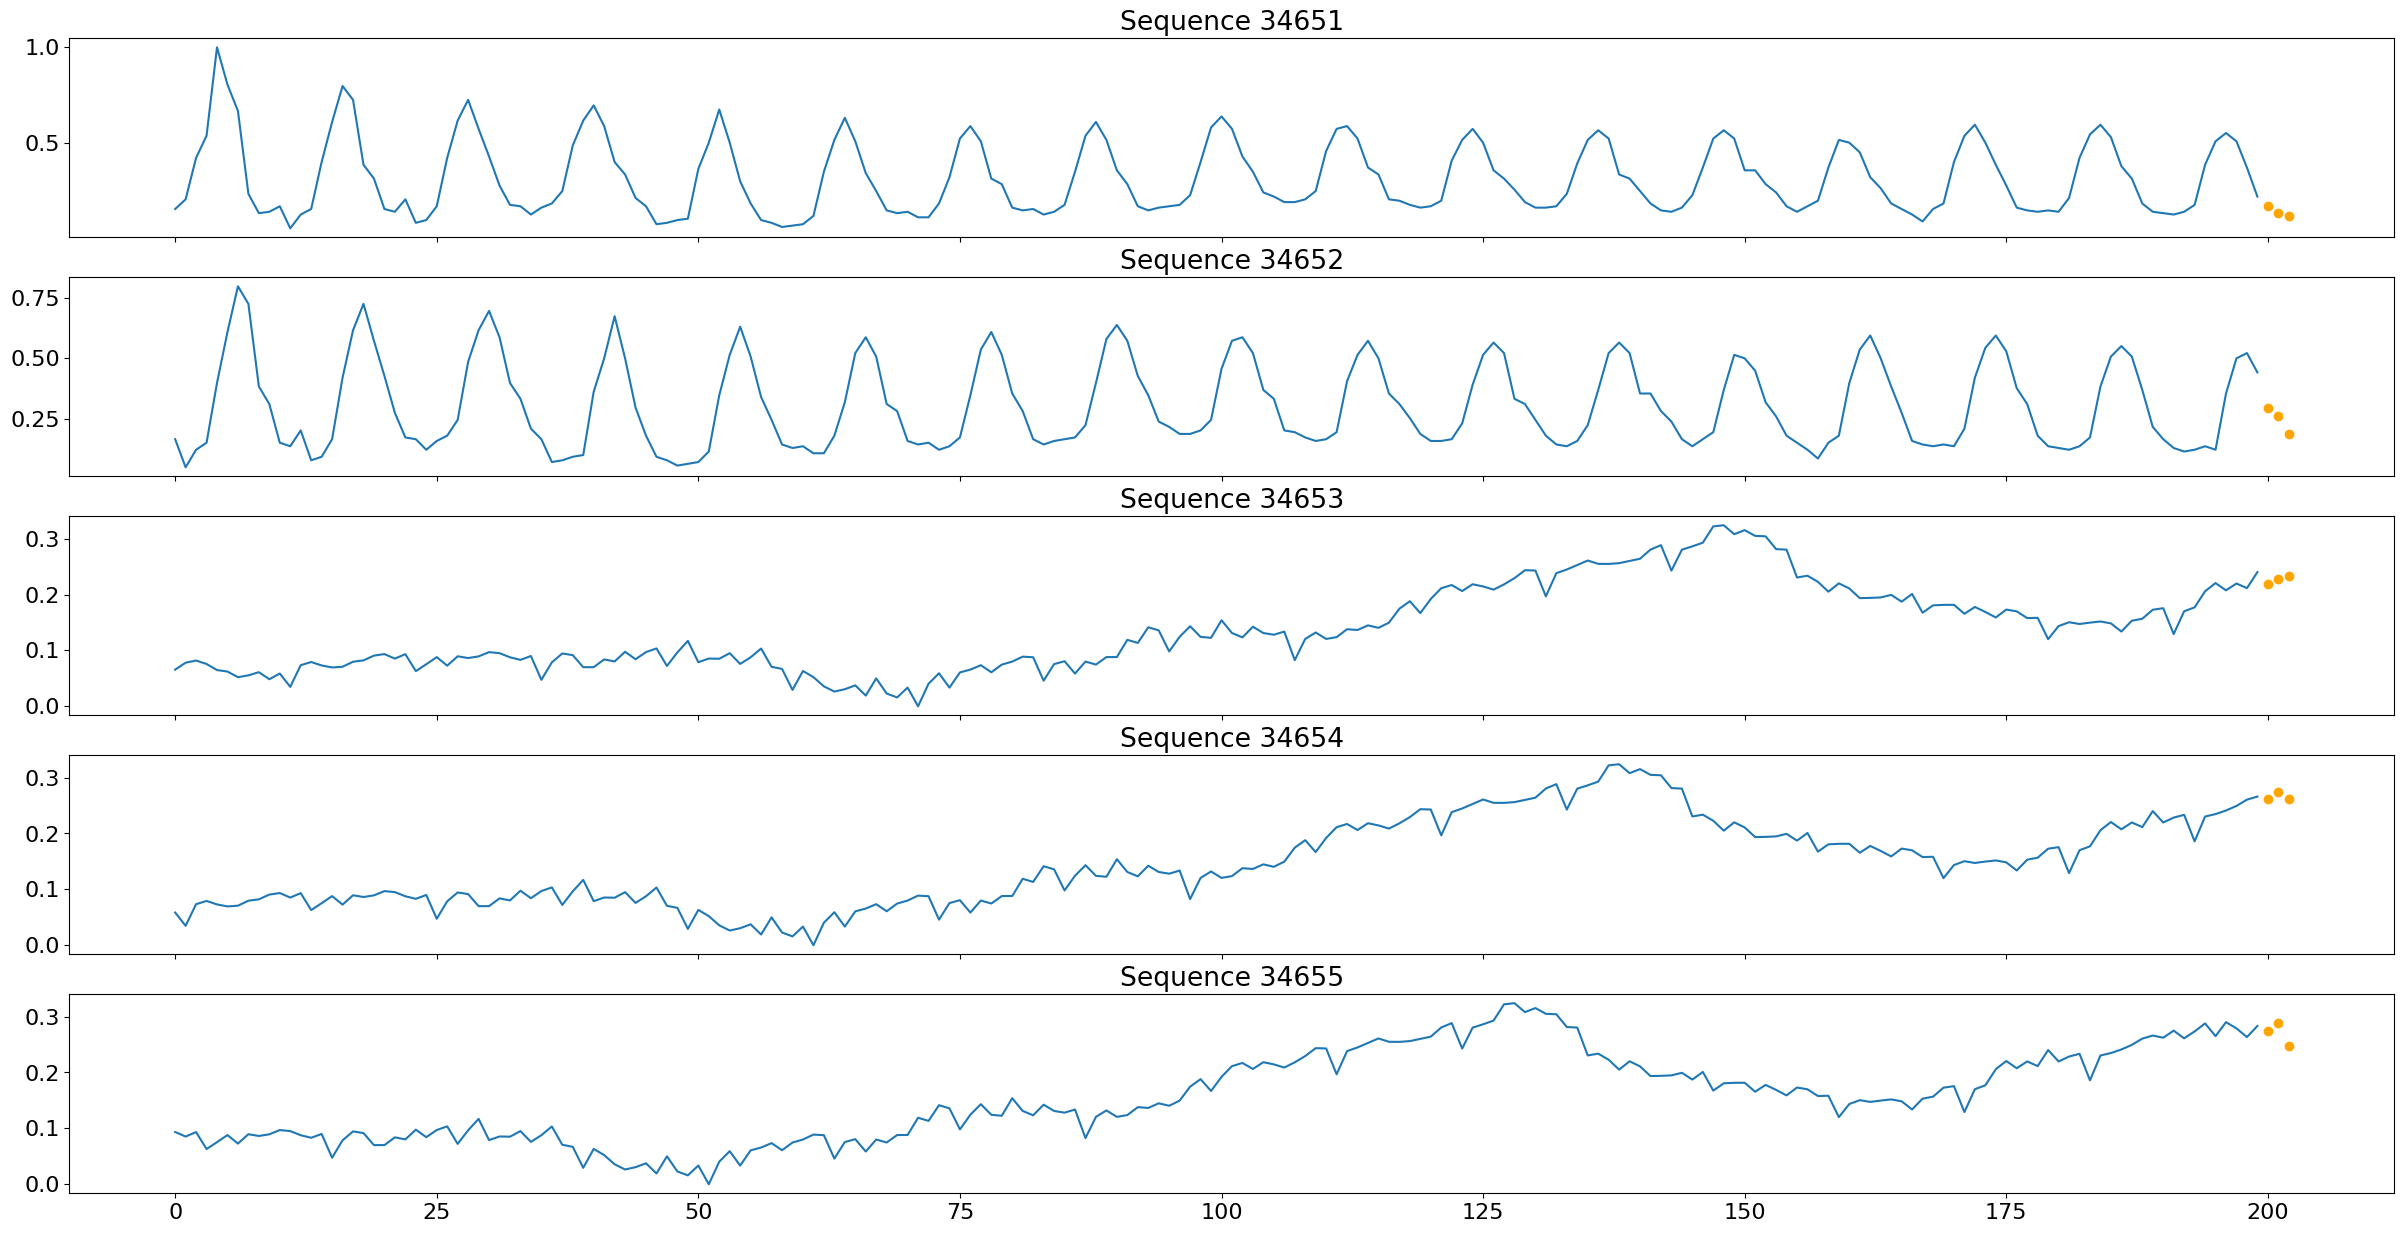

In [12]:
inspect_multivariate(X_train, y_train, AUTOREGRESSIVE_TELESCOPE)

In [ ]:
# Define input and output shape for the forecasting model

print(X_train.shape)
print(X_val.shape)
print(X_test_reg.shape)

input_shape = X_train.shape[1:]
output_shape = y_train.shape[1:]

print(input_shape)
print(output_shape)

(199448, 200)
(49548, 200)
(6998, 200)
(200,)
(3,)


# **FORECASTING MODEL DEFINITION**

---

In [ ]:


# -----------------------------------* FORECASTING MODEL DEFINITION *---------------------------------------

def build_FC_model(input_shape, output_shape):
    # Ensure the input time steps are at least as many as the output time steps
    assert input_shape[0] >= output_shape[0], "For this exercise we want input time steps to be >= of output time steps"

    # Define the input layer with the specified shape
    input_layer = tfkl.Input(shape=input_shape, name='input_layer')

    # Define the first dense layers, with 32 neurons and relu activation
    x = tfkl.Dense(32, activation='relu')(input_layer)

    # Second dense layer, with 16 neurons and relu activation
    x = tfkl.Dense(16, activation='relu')(x)

    # Third dense layer, with 8 neurons and relu activation
    x = tfkl.Dense(8, activation='relu')(x)

    # Fourth dense layer, with 4 neurons and relu activation
    x = tfkl.Dense(4, activation='relu')(x)

    # Output
    output_layer = tfkl.Dense(3, activation='sigmoid')(x)

    # Construct the model by connecting input and output layers
    model = tf.keras.Model(inputs=input_layer, outputs=output_layer, name='FC_model')

    # Compile the model with Mean Squared Error loss and Adam optimizer
    model.compile(loss=tf.keras.losses.MeanSquaredError(), optimizer=tf.keras.optimizers.Adam(), metrics = 'mse')

    return model

Model: "FC_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 200)]             0         
                                                                 
 dense (Dense)               (None, 64)                12864     
                                                                 
 dense_1 (Dense)             (None, 32)                2080      
                                                                 
 dense_2 (Dense)             (None, 16)                528       
                                                                 
 dense_3 (Dense)             (None, 8)                 136       
                                                                 
 dense_4 (Dense)             (None, 3)                 27        
                                                                 
Total params: 15635 (61.07 KB)
Trainable params: 15635 (61

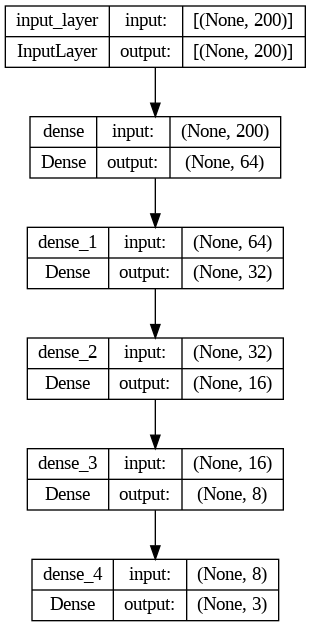

In [ ]:
model = build_FC_model(input_shape, output_shape)
model.summary()
tfk.utils.plot_model(model, expand_nested=True, show_shapes=True)

In [ ]:
# Train the model
history = model.fit(
    x = X_train,
    y = y_train,
    batch_size = BATCH_SIZE,
    epochs = EPOCHS,
    validation_data=(X_val, y_val),
    callbacks = [
        tfk.callbacks.EarlyStopping(monitor='val_loss', mode='min', patience=8, restore_best_weights=True),
        tfk.callbacks.ReduceLROnPlateau(monitor='val_loss', mode='min', patience=8, factor=0.1, min_lr=1e-5)]
).history

Epoch 1/100
780/780 [==============================] - 9s 5ms/step - loss: 0.0117 - mse: 0.0117 - val_loss: 0.0047 - val_mse: 0.0047 - lr: 0.0010
Epoch 2/100
780/780 [==============================] - 3s 4ms/step - loss: 0.0047 - mse: 0.0047 - val_loss: 0.0043 - val_mse: 0.0043 - lr: 0.0010
Epoch 3/100
780/780 [==============================] - 3s 4ms/step - loss: 0.0044 - mse: 0.0044 - val_loss: 0.0042 - val_mse: 0.0042 - lr: 0.0010
Epoch 4/100
780/780 [==============================] - 5s 6ms/step - loss: 0.0042 - mse: 0.0042 - val_loss: 0.0041 - val_mse: 0.0041 - lr: 0.0010
Epoch 5/100
780/780 [==============================] - 4s 5ms/step - loss: 0.0041 - mse: 0.0041 - val_loss: 0.0045 - val_mse: 0.0045 - lr: 0.0010
Epoch 6/100
780/780 [==============================] - 4s 5ms/step - loss: 0.0041 - mse: 0.0041 - val_loss: 0.0040 - val_mse: 0.0040 - lr: 0.0010
Epoch 7/100
780/780 [==============================] - 4s 5ms/step - loss: 0.0040 - mse: 0.0040 - val_loss: 0.0040 - val_mse

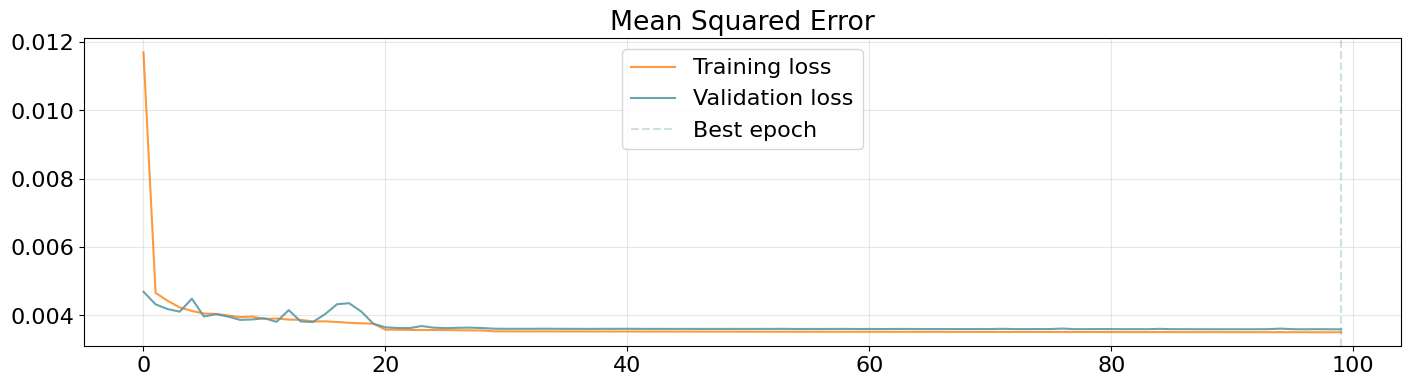

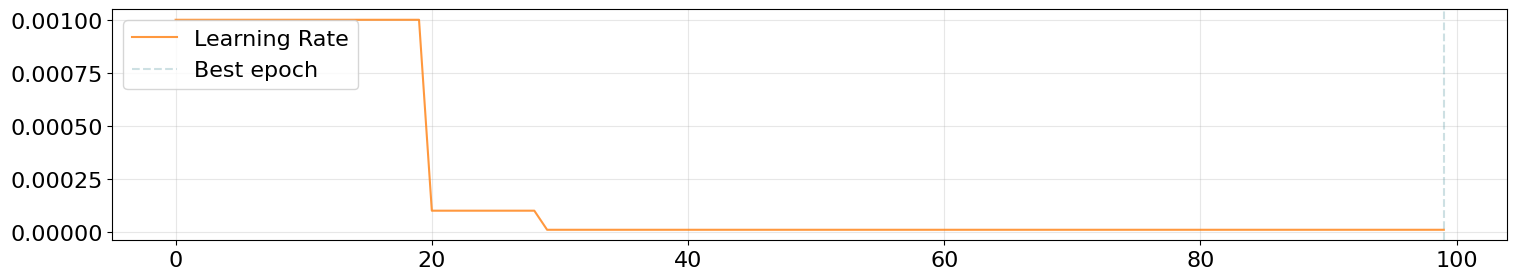

In [ ]:
best_epoch = np.argmin(history['val_loss'])
plt.figure(figsize=(17,4))
plt.plot(history['loss'], label='Training loss', alpha=.8, color='#ff7f0e')
plt.plot(history['val_loss'], label='Validation loss', alpha=.9, color='#5a9aa5')
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
plt.title('Mean Squared Error')
plt.legend()
plt.grid(alpha=.3)
plt.show()

plt.figure(figsize=(18,3))
plt.plot(history['lr'], label='Learning Rate', alpha=.8, color='#ff7f0e')
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
plt.legend()
plt.grid(alpha=.3)
plt.show()


model.save('FC_Model')

In [ ]:
del model

In [35]:
model = tfk.models.load_model('FC_Model')
# Autoregressive Forecasting
reg_predictions = np.array([])
X_temp = X_test_reg
for reg in range(0,TELESCOPE,AUTOREGRESSIVE_TELESCOPE):
    pred_temp = model.predict(X_temp,verbose=0)
    if(len(reg_predictions)==0):
        reg_predictions = pred_temp
    else:
        reg_predictions = np.concatenate((reg_predictions,pred_temp),axis=1)
    X_temp = np.concatenate((X_temp[:,AUTOREGRESSIVE_TELESCOPE:],pred_temp), axis=1)


In [36]:
# Print the shape of the predictions
print(f"Predictions shape: {reg_predictions.shape}")

# Calculate and print Mean Squared Error (MSE)
mean_squared_error = tfk.metrics.mean_squared_error(y_test_reg.flatten(), reg_predictions.flatten()).numpy()
print(f"Mean Squared Error: {mean_squared_error}")

# Calculate and print Mean Absolute Error (MAE)
mean_absolute_error = tfk.metrics.mean_absolute_error(y_test_reg.flatten(), reg_predictions.flatten()).numpy()
print(f"Mean Absolute Error: {mean_absolute_error}")

Predictions shape: (7359, 18)
Mean Squared Error: 0.008646446280181408
Mean Absolute Error: 0.059609100222587585


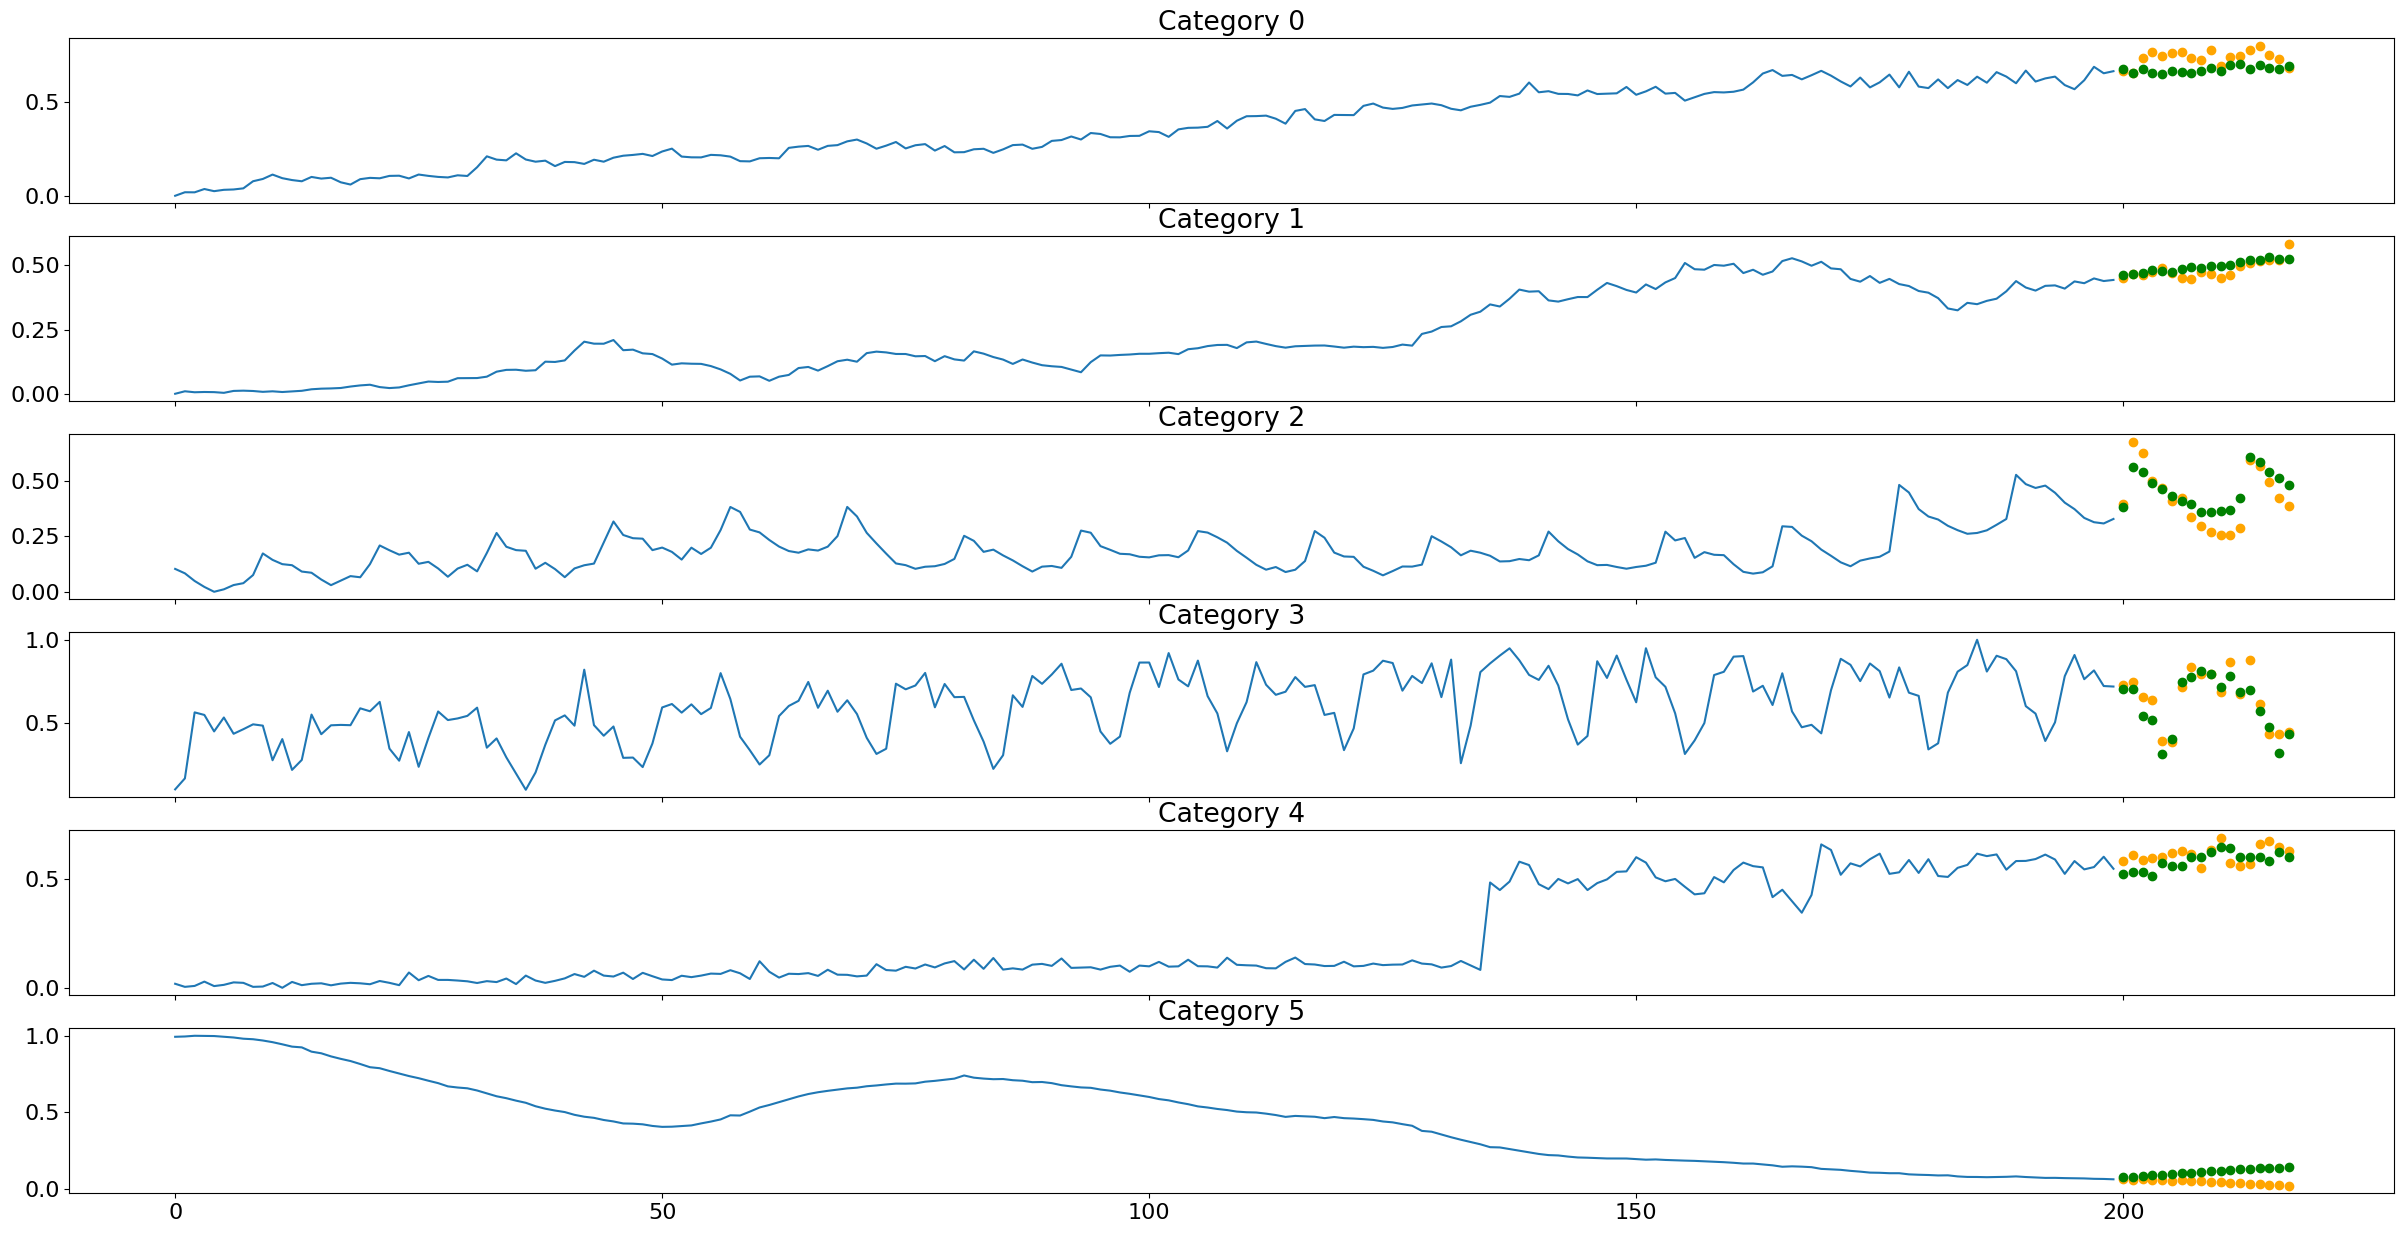

In [38]:
inspect_multivariate_prediction(X_test_reg, y_test_reg,reg_predictions, TELESCOPE, test_categories, idx = 0)